Project  Airline AI Assistant
-Lets Make more intractive by adding more feature


In [1]:
import os
import json
from dotenv import load_dotenv
from openai import OpenAI
import gradio as gr

In [2]:
# Initialization

load_dotenv(override=True)

openai_api_key = os.getenv('OPENAI_API_KEY')
if openai_api_key:
    print(f"OpenAI API Key exists and begins {openai_api_key[:8]}")
else:
    print("OpenAI API Key not set")
    
MODEL = "gpt-4o-mini"
openai = OpenAI()

OpenAI API Key exists and begins sk-proj-


In [3]:

system_message = "You are a helpful assistant for an Airline called FlightAI. "
system_message += "Give short, courteous answers, no more than 1 sentence. "
system_message += "Always be accurate. If you don't know the answer, say so."

In [4]:
def chat(message,history):
    messages = [{"role":"system","content":system_message}] + history + [{"role":"user","content":message}]
    response = openai.chat.completions.create(
        model=MODEL,
        messages=messages
    )
    return response.choices[0].message.content
gr.ChatInterface(fn=chat,type="messages").launch()


* Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


## Tools

Tools are powerful feature provided by the frontier LLMs.

By using Tools we can write function and have the LLM call that function as part of its response.

In [7]:
# Create a ticket funcion
ticket_prices = {"london": "$799", "paris": "$899", "tokyo": "$1400", "berlin": "$499"}

def get_ticket_price(destination_city):
    print(f"Tool get_ticket_price called for {destination_city}")
    city = destination_city.lower()
    return ticket_prices.get(city, "Unknown")

In [8]:
get_ticket_price("London")

Tool get_ticket_price called for London


'$799'

In [9]:
# dictionary structure that's required to describe our function:
price_function = {
    "name": "get_ticket_price",
    "description": "Get the price of a return ticket to the destination city. Call this whenever you need to know the ticket price, for example when a customer asks 'How much is a ticket to this city'",
    "parameters": {
        "type": "object",
        "properties": {
            "destination_city": {
                "type": "string",
                "description": "The city that the customer wants to travel to",
            },
        },
        "required": ["destination_city"],
        "additionalProperties": False
    }
}

In [10]:
# And this is included in a list of tools

tools = [{"type":"function","function": price_function}]

In [11]:
# We have to write that function handle_tool_call:

def handle_tool_call(message):
    tool_call = message.tool_calls[0]
    arguments = json.loads(tool_call.function.arguments)
    city = arguments.get('destination_city')
    price = get_ticket_price(city)
    response = {
        "role": "tool",
        "content": json.dumps({"destination_city": city,"price": price}),
        "tool_call_id": tool_call.id
    }
    return response, city

In [12]:
# OpenAI to use Our Tools

def chat(message, history):
    messages = [{"role": "system", "content": system_message}] + history + [{"role": "user", "content": message}]
    response = openai.chat.completions.create(model=MODEL, messages=messages, tools=tools)

    if response.choices[0].finish_reason=="tool_calls":
        message = response.choices[0].message
        response, city = handle_tool_call(message)
        messages.append(message)
        messages.append(response)
        response = openai.chat.completions.create(model=MODEL, messages=messages)
    
    return response.choices[0].message.content



In [13]:
gr.ChatInterface(fn=chat,type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862

To create a public link, set `share=True` in `launch()`.


## Build with multi-modal!!
We can use DALL-E-3, the image generation model behind GPT-4o, to make us some images

In [14]:
import base64
from io import BytesIO
from PIL import Image

In [15]:
def artist(city):
    image_response = openai.images.generate(
        model = "dall-e-3",
        prompt=f"An image representing a vacation in {city}, showing tourist spots and everything unique about {city}, in a vibrant pop-art style",
        size="1024x1024",
        n=1,
        response_format="b64_json",
    )

    image_base64 = image_response.data[0].b64_json
    image_data = base64.b64decode(image_base64)
    return Image.open(BytesIO(image_data))

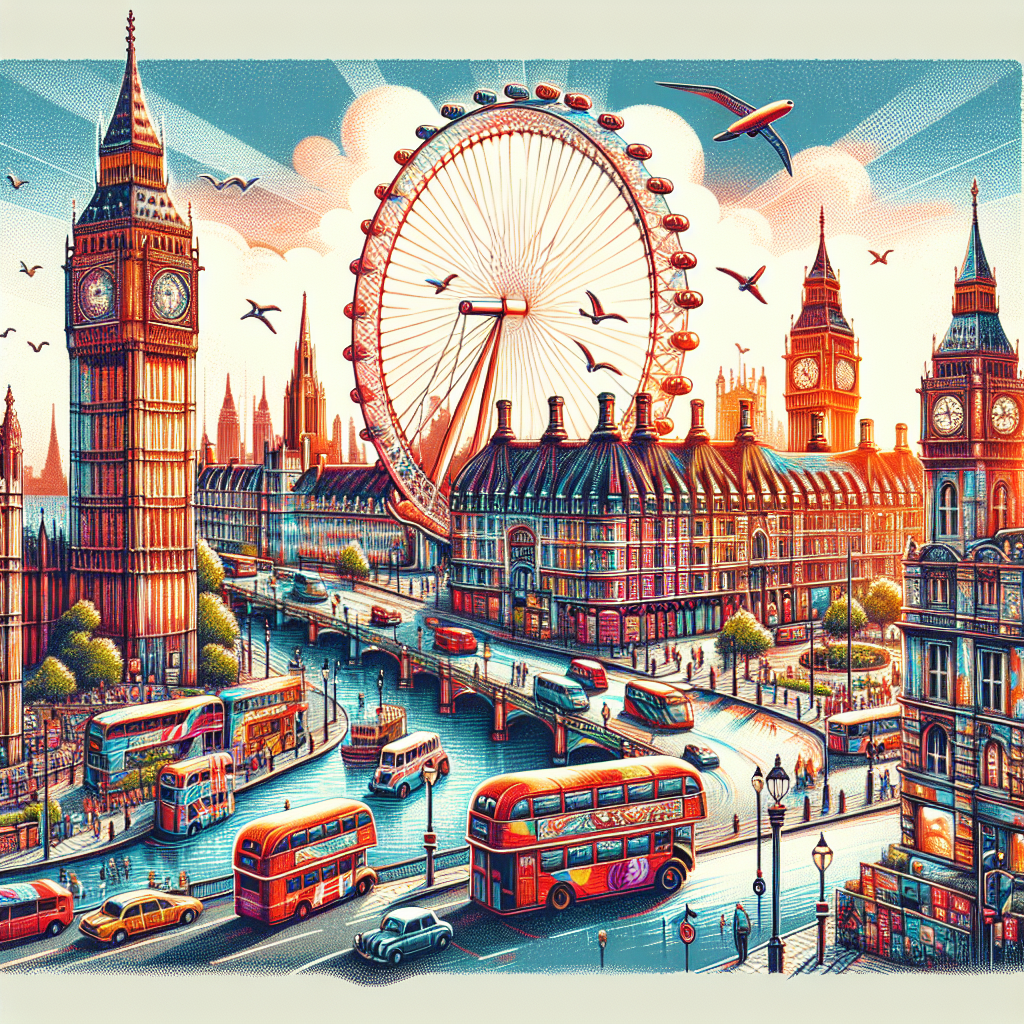

In [17]:
image = artist("London City")
display(image)

Audio :
Make function talker that uses OpenAI's speech model to generate Audio

In [19]:
## Install library
!pip install simpleaudio

     ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
     ------------------------------ --------- 1.6/2.0 MB 9.4 MB/s eta 0:00:01
     ---------------------------------------- 2.0/2.0 MB 6.0 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for simpleaudio: filename=simpleaudio-1.0.4-cp310-cp310-win_amd64.whl size=2039170 sha256=7c743154606f06bd8feaf959b8645eba9ebc344a18250a95304ba6546c926c47
  Stored in directory: c:\users\acer\appdata\local\pip\cache\wheels\10\70\ed\8c41675109565c2c65c3ac40d20859fc9d3f93a8efbb11d1c7
Successfully built simpleaudio



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [55]:
## Below code not working due to some file not found error , So doing in diffrent way
# from pydub import AudioSegment
# from io import BytesIO
# import tempfile
# import os
# import simpleaudio as sa

# def talker(message):
#     response = openai.audio.speech.create(
#         model="tts-1",
#         voice="onyx",  # Also, try replacing onyx with alloy
#         input=message
#     )
    
#     audio_stream = BytesIO(response.content)
#     audio = AudioSegment.from_file(audio_stream, format="mp3")

#     # Create a temporary file in a folder where you have write permissions
#     with tempfile.NamedTemporaryFile(suffix=".wav", delete=False, dir=os.path.expanduser("~/Documents")) as temp_audio_file:
#         temp_file_name = temp_audio_file.name
#         audio.export(temp_file_name, format="wav")
    
#     # Load and play audio using simpleaudio
#     wave_obj = sa.WaveObject.from_wave_file(temp_file_name)
#     play_obj = wave_obj.play()
#     play_obj.wait_done()  # Wait for playback to finish

#     # Clean up the temporary file afterward
#     os.remove(temp_file_name)
    
# talker("Well hi there")

# Different Way

import openai
import tempfile
import os
import platform
import subprocess

def talker(message):
    # Step 1: Get MP3 audio from OpenAI
    response = openai.audio.speech.create(
        model="tts-1",
        voice="onyx",
        input=message
    )

    # Step 2: Save MP3 to temp file
    with tempfile.NamedTemporaryFile(suffix=".mp3", delete=False) as temp_mp3_file:
        mp3_path = temp_mp3_file.name
        temp_mp3_file.write(response.content)

    # Step 3: Play MP3 using system default media player
    if platform.system() == "Windows":
        os.startfile(mp3_path)  # Opens in default player
    elif platform.system() == "Darwin":  # macOS
        subprocess.call(["open", mp3_path])
    else:  # Linux
        subprocess.call(["xdg-open", mp3_path])

# Test
talker("This is text to speech generation.")


# Agentic Framework
An Agentic AI Framework enables autonomous AI agents to plan, use tools, collaborate, and retain memory to solve complex problems.
It involves breaking tasks into steps, assigning them to specialized agents, and orchestrating their actions in an agent environment.

In [52]:
def chat(history):
  messages = [{"role":"system","content":system_message}] + history
  response = openai.chat.completions.create(
      model=MODEL,
      messages=messages,
      tools=tools
  )
  image = None

  if response.choices[0].finish_reason == "tool_calls":
    message = response.choices[0].message
    response,city = handle_tool_call(message)
    messages.append(message)
    messages.append(response)
    image = artist(city)
    response = openai.chat.completions.create(model=MODEL, messages=messages)
  
  reply = response.choices[0].message.content
  history += [{"role":"assistant","content":reply}]

  talker(reply)
  return history,image

   

In [ ]:
with gr.Blocks() as ui:
    with gr.Row():
        chatbot = gr.Chatbot(height=500, type="messages")
        image_output = gr.Image(height=500)
    with gr.Row():
        entry = gr.Textbox(label="Chat with our AI Assistant:")
    with gr.Row():
        clear = gr.Button("Clear")

    def do_entry(message, history):
        history += [{"role":"user", "content":message}]
        return "", history

    entry.submit(do_entry, inputs=[entry, chatbot], outputs=[entry, chatbot]).then(
        chat, inputs=chatbot, outputs=[chatbot, image_output]
    )
    clear.click(lambda: None, inputs=None, outputs=chatbot, queue=False)

ui.launch(inbrowser=True)

* Running on local URL:  http://127.0.0.1:7869

To create a public link, set `share=True` in `launch()`.


Tool get_ticket_price called for London
Tool get_ticket_price called for France
